In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from scipy import stats
from pathlib import Path

import matplotlib.pyplot as plt

from assistive_arm.utils.plotting import extract_muscle_activations, plot_res_assist_forces

In [2]:
subject_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Masterarbeit Harvard/Thesis/Subject testing/Subject data/subject_1")
trial = subject_data / "trial_2"

df_assist_false = pd.read_csv("../moco/control_solutions/opencap_simple_assistance_false_2023-09-25_16-20.sto", delimiter="\t", skiprows=18)
df_assist_true_reduced_activation = pd.read_csv("../moco/control_solutions/opencap_simple_assistance_true_2023-09-19_16-06.sto", delimiter="\t", skiprows=18)

ground_forces = pd.read_csv(str(trial / "grf_filtered.mot"), delimiter="\t", skiprows=6)
ground_forces = ground_forces[(ground_forces["time"] >= 1.8) & (ground_forces["time"] <= 3.2)]

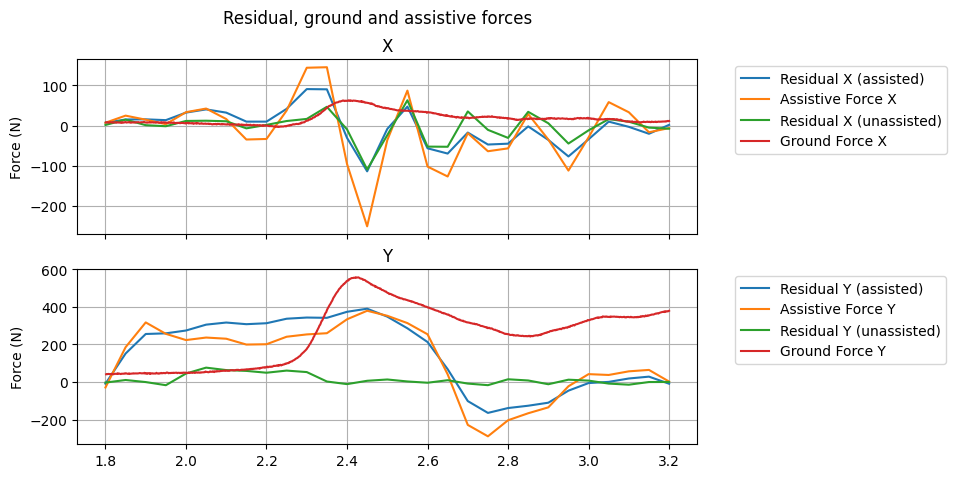

In [3]:
dfs = {}
dfs["assist_false"] = df_assist_false
dfs["assist_true"] = df_assist_true_reduced_activation
dfs["ground_forces"] = ground_forces

plot_res_assist_forces(time=df_assist_true_reduced_activation.time, dataframes=dfs, figsize=(8,5))

### Plot residual forces

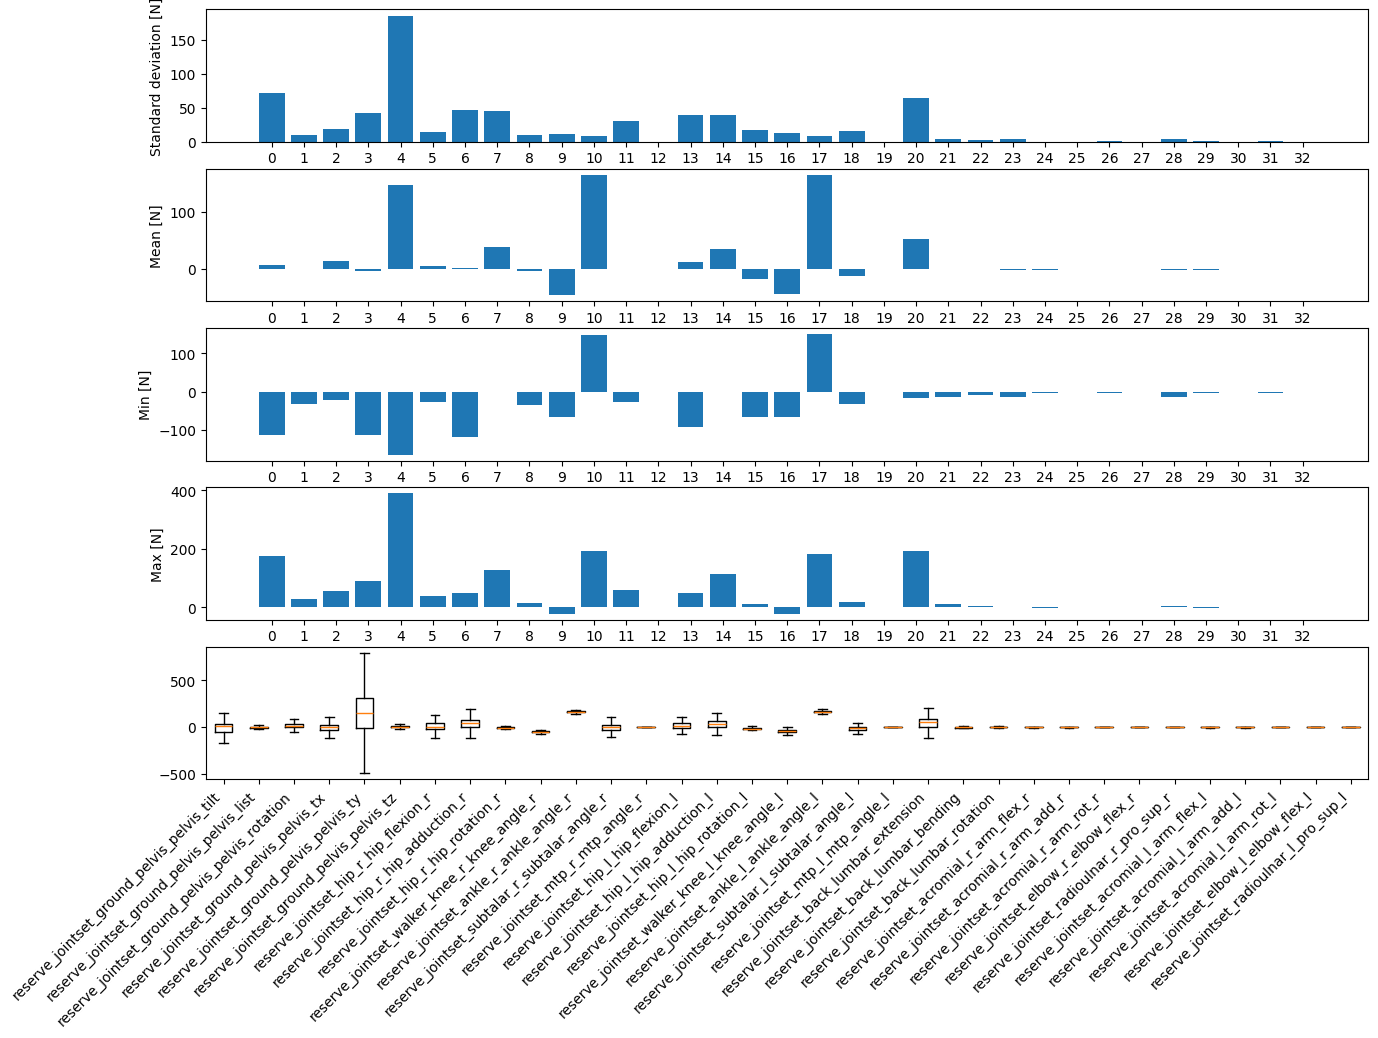

In [4]:
def plot_residual_forces(df: pd.DataFrame) -> None:
    # Extract columns corresponding to reserve actuators
    reserve_columns = [col for col in df.columns if "reserve" in col]
    df_assist_true_reserve = df[reserve_columns]
    df_assist_true_reserve.columns = [col.split("/")[2] for col in reserve_columns]

    fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=False)

    axs[0].bar(df_assist_true_reserve.columns, df_assist_true_reserve.std(axis=0)*350)
    axs[0].set_ylabel("Standard deviation [N]")
    axs[0].set_xticks(range(len(df_assist_true_reserve.columns)))
    axs[0].set_xticklabels(range(len(df_assist_true_reserve.columns)))

    axs[1].bar(df_assist_true_reserve.columns, df_assist_true_reserve.mean(axis=0)*350)
    axs[1].set_ylabel("Mean [N]")
    axs[1].set_xticks(range(len(df_assist_true_reserve.columns)))
    axs[1].set_xticklabels(range(len(df_assist_true_reserve.columns)))

    axs[2].bar(df_assist_true_reserve.columns, df_assist_true_reserve.min(axis=0)*350)
    axs[2].set_ylabel("Min [N]")
    axs[2].set_xticks(range(len(df_assist_true_reserve.columns)))
    axs[2].set_xticklabels(range(len(df_assist_true_reserve.columns)))

    axs[3].bar(df_assist_true_reserve.columns, df_assist_true_reserve.max(axis=0)*350)
    axs[3].set_ylabel("Max [N]")
    axs[3].set_xticks(range(len(df_assist_true_reserve.columns)))
    axs[3].set_xticklabels(range(len(df_assist_true_reserve.columns)))


    
    means = df_assist_true_reserve.mean(axis=0)*350
    q1 = df_assist_true_reserve.quantile(0.25, axis=0)*350
    q3 = df_assist_true_reserve.quantile(0.75, axis=0)*350
    whislo = q1 - 1.5 * (q3 - q1)
    whishi = q3 + 1.5 * (q3 - q1)

    keys = ['med', 'q1', 'q3', 'whislo', 'whishi']
    stats = [dict(zip(keys, vals)) for vals in zip(means, q1, q3, whislo, whishi)]
    axs[4].bxp(stats, showfliers=False)
    axs[4].set_xticks(range(1, len(stats) + 1))
    axs[4].set_xticklabels(df_assist_true_reserve.columns, rotation=45, ha="right")

    # axs[3].bar(df_assist_true_reserve.columns, df_assist_true_reserve.min(axis=0)*350)
    # axs[3].set_title("Min of reserve actuator forces")
    # axs[3].set_ylabel("Min [N]")
    # axs[3].set_xticklabels(df_assist_true_reserve.columns, rotation=45, ha="right")

plot_residual_forces(df_assist_true_reduced_activation)

In [5]:
simple_df_false_activations = extract_muscle_activations(df_assist_false, apply_filter=False)
simple_df_true_reduced_activations = extract_muscle_activations(df_assist_true_reduced_activation, apply_filter=False)[simple_df_false_activations.columns]

# Only look at recfem and vasmed
simple_df_false_activations = simple_df_false_activations[["recfem_r", "vasmed_r", "recfem_l", "vasmed_l", "soleus_r", "soleus_l", "tibant_r", "tibant_l"]]
simple_df_true_reduced_activations = simple_df_true_reduced_activations[["recfem_r", "vasmed_r", "recfem_l", "vasmed_l", "soleus_r", "soleus_l", "tibant_r", "tibant_l"]]

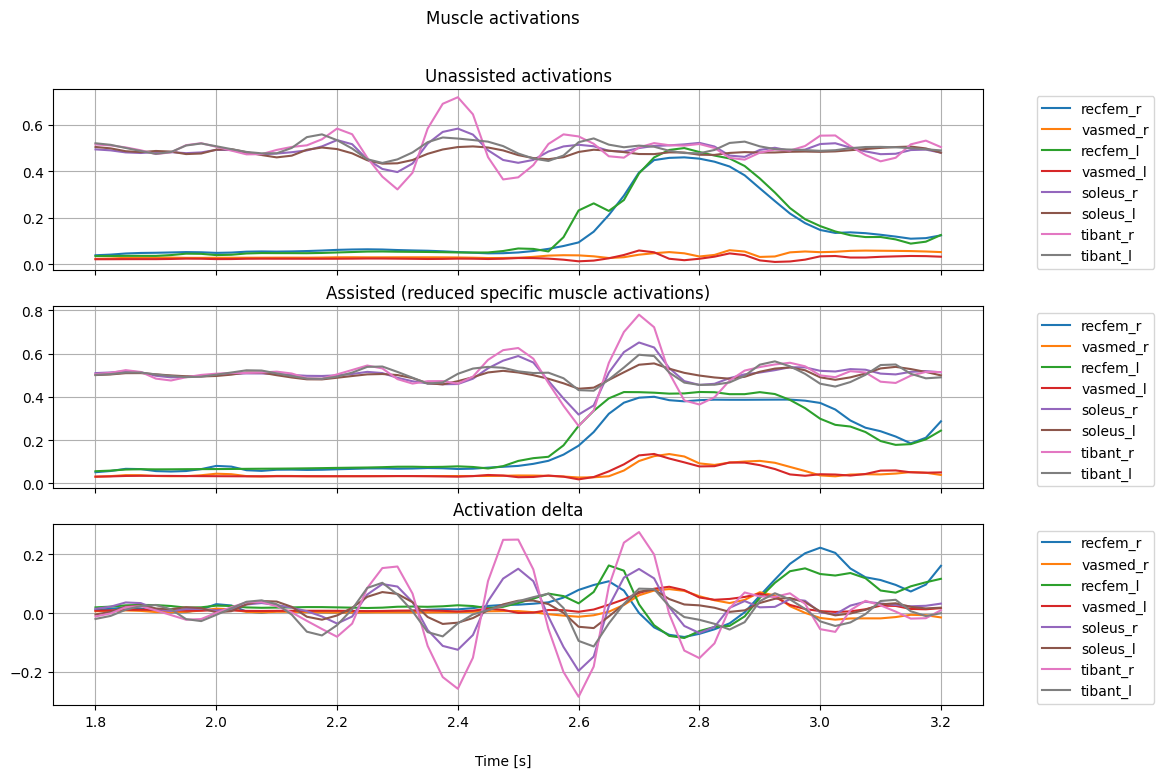

In [6]:
fig, axs = plt.subplots(3, figsize=(12, 8), sharex=True)

fig.suptitle("Muscle activations")

# Activations with no assistance
axs[0].plot(df_assist_false.time, simple_df_false_activations, label=simple_df_false_activations.columns)
axs[0].set_title('Unassisted activations')
axs[0].grid()
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axs[1].plot(df_assist_true_reduced_activation.time, simple_df_true_reduced_activations, label=simple_df_true_reduced_activations.columns)
axs[1].set_title('Assisted (reduced specific muscle activations)')
axs[1].grid()
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axs[2].plot(df_assist_true_reduced_activation.time, simple_df_true_reduced_activations - simple_df_false_activations, label=simple_df_true_reduced_activations.columns)
axs[2].set_title('Activation delta')
axs[2].grid()
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Define xlabel
fig.text(0.5, 0.04, 'Time [s]', ha='center', va='center')

# plt.tight_layout()
plt.show()

In [7]:
relevant_cols = []

for col in df_assist_true_reduced_activation.columns:
    if "jointset" and "pelvis" in col:
        relevant_cols.append(col)

In [8]:
relevant_cols = relevant_cols[3:6]
pelvis_df = df_assist_true_reduced_activation[relevant_cols]
pelvis_df.columns = [col.split("/")[3] for col in relevant_cols]

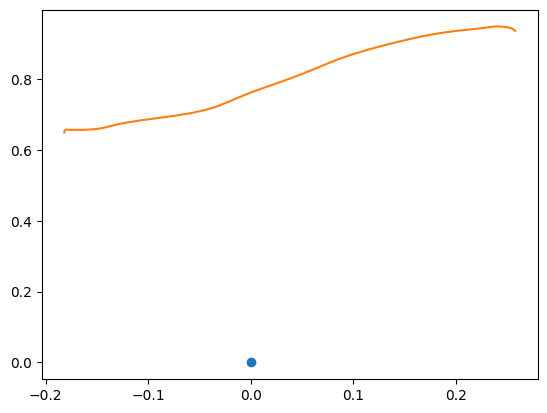

In [9]:
plt.plot(0, 0, label="origin", marker="o")
plt.plot(pelvis_df.pelvis_tx, pelvis_df.pelvis_ty, label="pelvis")